Import packages

In [83]:
import env_methods as em
import vis_methods as vis
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import matplotlib
import numpy as np
import datetime as dt
import math

Basic Parameters

In [174]:
#Define bounding box in North America
lat_start = 0
lat_end = 90
lon_start = -179
lon_end =  -30

#Data paths
main_path = r'C:\Users\bpara\Geo data'

temps_path = r'\temp'
geomean_path = r'\geopotential mean'
rain_path = r'\surface precip'
snow_path = r'\snow depth'
moisture_path = r'\soil moisture'
shum_path = r'\specific humidity'

#Visualization:
months = ["December", "January", "February", "March", "April", "May", "June"]

Import data

In [175]:
temp_data = em.get_data(main_path+temps_path, True)
temp_data["air"]=temp_data["nc_vars"].pop("air") #remove stacked structure
temp_data.pop("nc_vars")

geomean_data = em.get_data(main_path+geomean_path, True)
geomean_data["hgt"]=geomean_data["nc_vars"].pop("hgt")
geomean_data.pop("nc_vars")

rain_data = em.get_data(main_path+rain_path, True)
rain_data["apcp"] = rain_data["nc_vars"].pop("apcp")
rain_data.pop("nc_vars")

snow_data = em.get_data(main_path+snow_path, True)
snow_data["snod"]=snow_data["nc_vars"].pop("snod")
snow_data.pop("nc_vars")

moisture_data = em.get_data(main_path+moisture_path, True)
moisture_data["soilm"] = moisture_data["nc_vars"].pop("soilm")
moisture_data.pop("nc_vars")

shum_data = em.get_data(main_path + shum_path, True)
shum_data["shum"] = shum_data["nc_vars"].pop("shum")
shum_data.pop("nc_vars")

acquring data from air.2m.mon.mean.nc
acquring data from hgt.mon.mean.nc
acquring data from apcp.mon.mean.nc
acquring data from snod.mon.mean.nc
acquring data from soilm.mon.mean.nc
acquring data from shum.mon.mean.nc


{}

In [143]:
geomean_data

{'level': [1000, 850, 500],
 'lat': [-90.0,
  -89.0,
  -88.0,
  -87.0,
  -86.0,
  -85.0,
  -84.0,
  -83.0,
  -82.0,
  -81.0,
  -80.0,
  -79.0,
  -78.0,
  -77.0,
  -76.0,
  -75.0,
  -74.0,
  -73.0,
  -72.0,
  -71.0,
  -70.0,
  -69.0,
  -68.0,
  -67.0,
  -66.0,
  -65.0,
  -64.0,
  -63.0,
  -62.0,
  -61.0,
  -60.0,
  -59.0,
  -58.0,
  -57.0,
  -56.0,
  -55.0,
  -54.0,
  -53.0,
  -52.0,
  -51.0,
  -50.0,
  -49.0,
  -48.0,
  -47.0,
  -46.0,
  -45.0,
  -44.0,
  -43.0,
  -42.0,
  -41.0,
  -40.0,
  -39.0,
  -38.0,
  -37.0,
  -36.0,
  -35.0,
  -34.0,
  -33.0,
  -32.0,
  -31.0,
  -30.0,
  -29.0,
  -28.0,
  -27.0,
  -26.0,
  -25.0,
  -24.0,
  -23.0,
  -22.0,
  -21.0,
  -20.0,
  -19.0,
  -18.0,
  -17.0,
  -16.0,
  -15.0,
  -14.0,
  -13.0,
  -12.0,
  -11.0,
  -10.0,
  -9.0,
  -8.0,
  -7.0,
  -6.0,
  -5.0,
  -4.0,
  -3.0,
  -2.0,
  -1.0,
  0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0

Define a function to produce mean values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [5]:
def generate_means(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    dataset = data[datakey][start_index:end_index][::12]

    means = dict()
    means["lon"] = data["lon"][:]
    means["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(dataset)[0][level]
    else:
        temp = np.copy(dataset)[0]
    
    for year in dataset[1:]:
        if has_levels:
            temp+=year[:,:][level]
        else:
            temp+=year[:,:]
    temp = temp / (end_year - start_year)
    means["mean"] = np.copy(temp)
    return means

Define a function to produce (sample) standard deviation values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [6]:
def generate_stddev(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    
    dataset = np.copy(data[datakey][start_index:end_index][::12])
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddev = dict()
    stddev["lat"] = data["lat"][:]
    stddev["lon"] = data["lon"][:]
    
    if has_levels:
        temp = np.square(dataset[0][level]-means)
    else:
        temp = np.square(dataset[0]-means)
        
    for year in range(1, len(dataset)):
        if has_levels:
            temp+=np.square(dataset[year][level]- means)
        else:
            temp+=np.square(dataset[year]-means)
    temp = temp / (end_year - start_year - 1)
    temp = np.sqrt(temp)
    
    stddev["stddev"] = np.copy(temp)
    
    return stddev

Define a function to produce a z-score for each data point to tell how many standard deviations from the mean it is for a given month when compared to a given date range

In [7]:
def generate_z_score(data, datakey, month, start_year, end_year, focus_year, has_levels, level=0):
    focus_time = dt.datetime(focus_year, month, 1)
    focus_index = em.find_closest_val(focus_time, data["time"])
    
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddevs = np.copy(generate_stddev(data, datakey, month, start_year, end_year, has_levels, level)["stddev"])
    
    z_score = dict()
    z_score["lon"] = data["lon"][:]
    z_score["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(data[datakey][focus_index][level])
    else:
        temp = np.copy(data[datakey][focus_index])
    temp = temp - means
    temp = temp / stddevs
    
    z_score["score"] = np.copy(temp)
    
    return z_score

In [ ]:
def generate_absolute_anomaly():
    
    

In [ ]:
def generate_correlation_area():
    
    

In [ ]:
def generate_correlation_dataset():
    
    

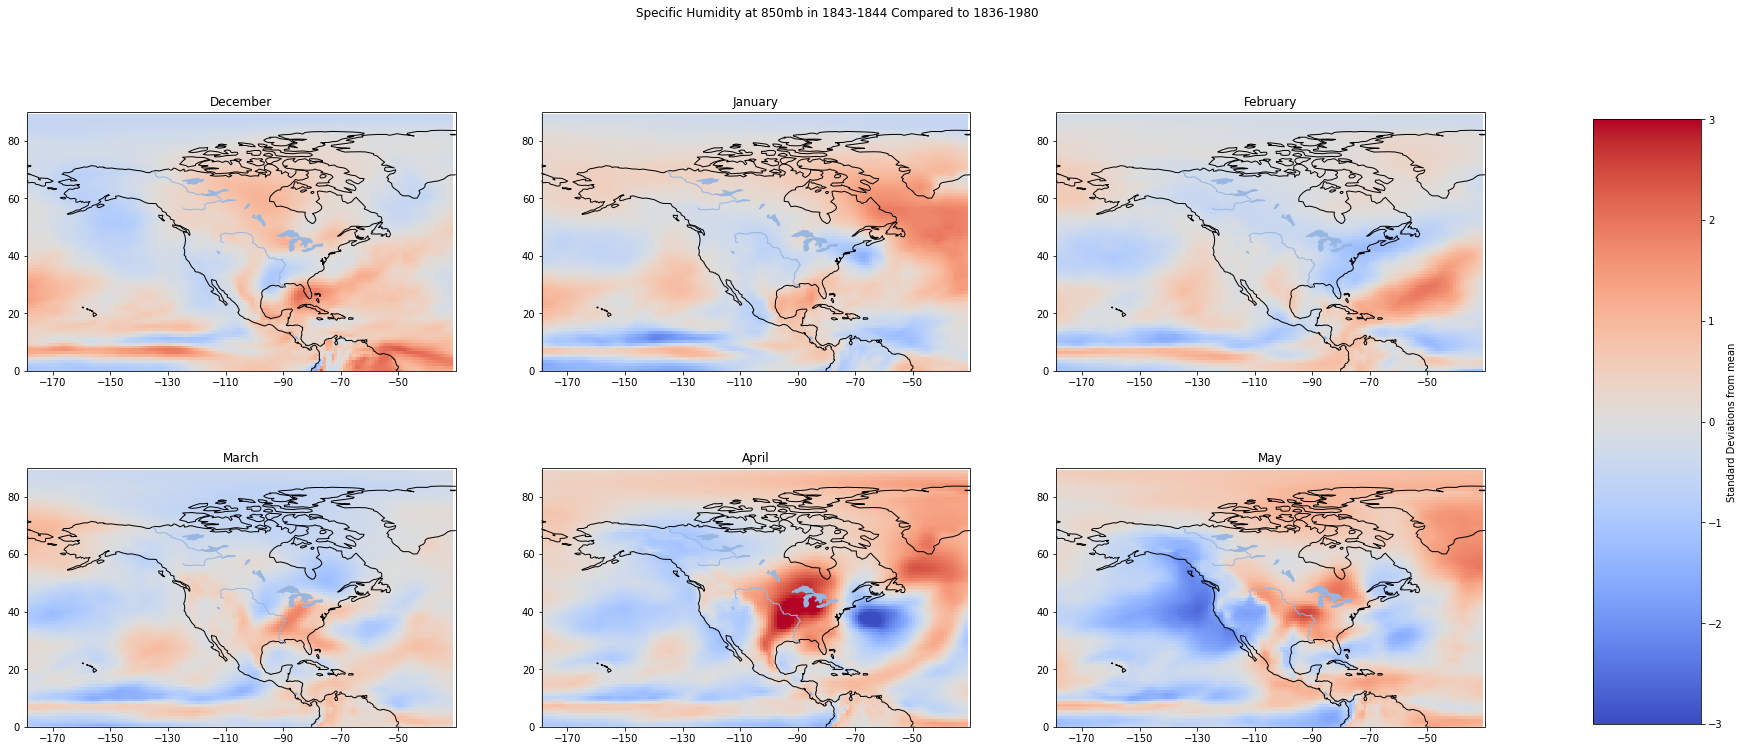

In [177]:
#This is also a bad function, but can (in theory) be salvaged to not be so specific

def generate_six_month_plot(fname, scalebar, title, data, datakey, start_year, end_year, focus_year, has_levels, level=0, 
                           lon_min = 0, lon_max = 359, lat_min = -90, lat_max = 90, 
                            has_scale_bounds = False, scale_min = -3, scale_max = 3):
    
    lat1 = em.find_closest_val(lat_min, data["lat"])
    lat2 = em.find_closest_val(lat_max, data["lat"])
    
    mesh = None
    
    fig, axs = plt.subplots(2,3, figsize=(30, 12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 0)})
    for x in range(len(axs)):
        for y in range(len(axs[x])):
            axs[x][y].coastlines()
            axs[x][y].add_feature(cartopy.feature.LAKES, alpha=1)
            axs[x][y].add_feature(cartopy.feature.RIVERS, alpha = 1)
            axs[x][y].set_extent((lon_min, lon_max, lat_min, lat_max))
            axs[x][y].set_xticks(data["lon"][math.ceil(lon_min / 10) * 10:lon_max][::20], crs = ccrs.PlateCarree())
            axs[x][y].set_yticks(data["lat"][math.ceil(lat1 / 10) * 10:lat2][::20], crs = ccrs.PlateCarree())
            axs[x][y].set_title(months[3*x+y])
            time_data = None
            if x + y == 0:
                time_data = [12, focus_year-1]
            else:
                time_data = [3*x+y, focus_year]
             
            plot_data = generate_z_score(data, datakey, time_data[0], start_year, end_year, time_data[1] , 
                                               has_levels, level)
            
            mesh = axs[x][y].pcolor(plot_data["lon"][lon_min:lon_max], 
                              plot_data["lat"][lat1:lat2], 
                              plot_data["score"][lat1:lat2, lon_min:lon_max], cmap="coolwarm", vmin =-scale_min, vmax = scale_max)
            
            
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    bar = fig.colorbar(mesh, cax=cbar_ax)
    bar.set_label(scalebar)
    
    fig.suptitle(title)
    
    plt.savefig(fname)
            
generate_six_month_plot("specific humidity 850mb.png", "Standard Deviations from mean", "Specific Humidity at 850mb in 1843-1844 Compared to 1836-1980",
                        shum_data, "shum", 1836, 1980, 1844, has_levels=True, level = 1, lon_min = lon_start, lon_max = lon_end, 
                        lat_min = lat_start, lat_max = lat_end, has_scale_bounds = True, scale_min = 3, scale_max = 3)

{'lon': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 15

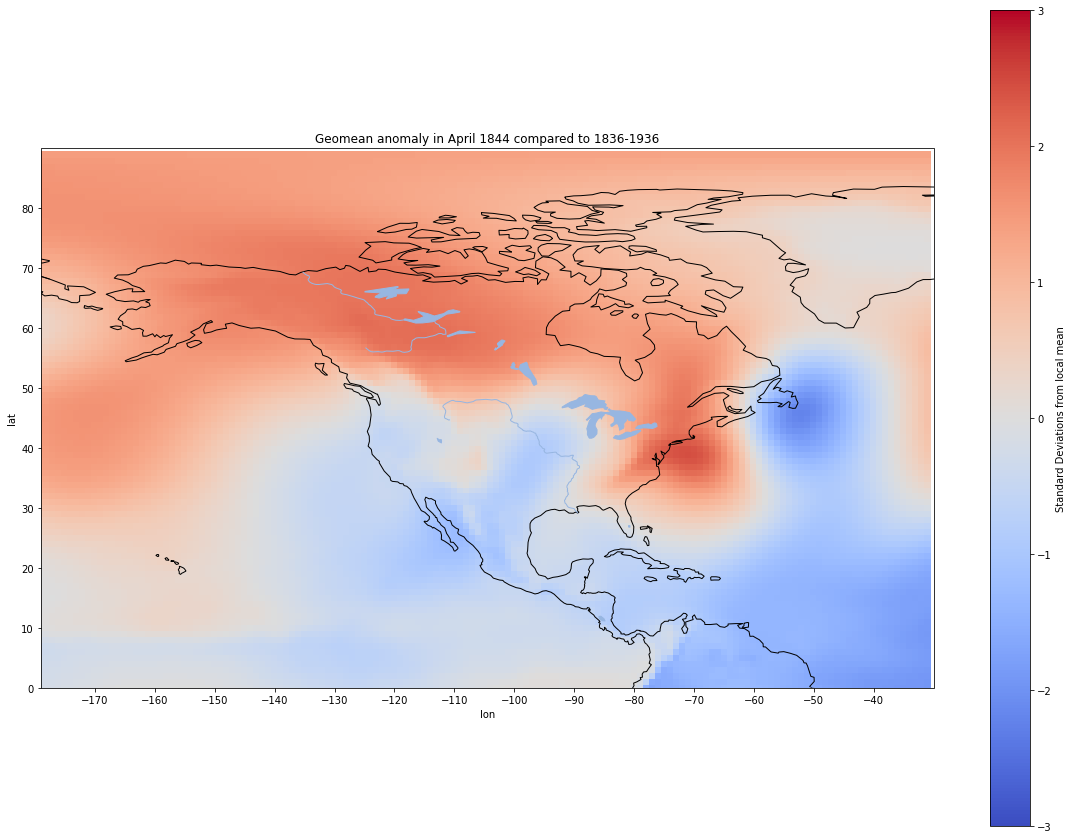

In [156]:
geo_z_score = generate_z_score(geomean_data, "hgt", 4, 1836, 1936, 1844, True, 0)

print(geo_z_score)

vis.plot_data(geo_z_score["lon"], geo_z_score["lat"], geo_z_score["score"], 
              "Standard Deviations from local mean", "Geomean anomaly in April 1844 compared to 1836-1936", 
              has_scale_bounds = True, scale_min = -3, scale_max = 3, 
              lon_min = lon_start, lon_max = lon_end, lat_min = lat_start, lat_max = lat_end)

NameError: name 'x' is not defined

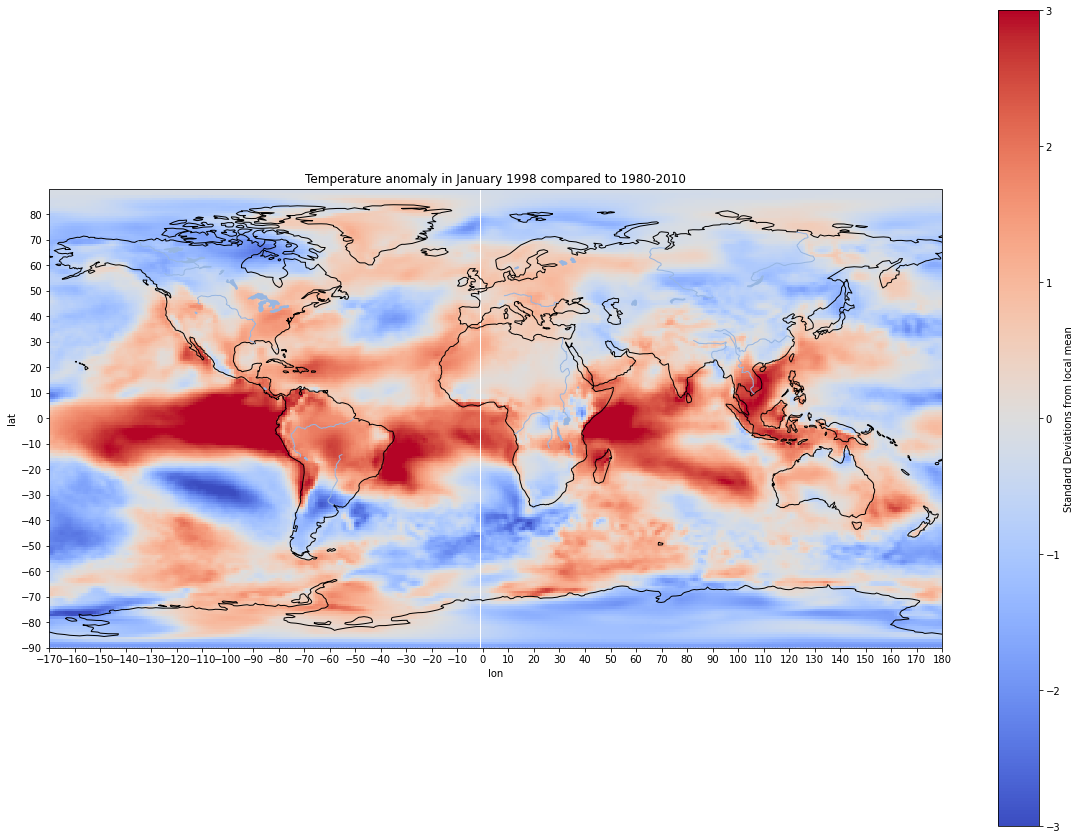

In [97]:
temp_z_score = generate_z_score(temp_data, "air", 1, 1980, 2010, 1998, False)

vis.plot_data(temp_z_score["lon"], temp_z_score["lat"], temp_z_score["score"], 
              "Standard Deviations from local mean", "Temperature anomaly in January 1998 compared to 1980-2010",
              has_scale_bounds = True, scale_min = -3, scale_max = 3)